# NAT CW!!

# Problem 1 - The effect of the population size.


For a constant total number of evaluations of the cost function and for a fixed problem difficulty, determine (approximately) the optimal population size.

In [1]:

# initialising PSO
# code obtained from worksheet provided in tutorial "ParticleSwarm.ipynb"

import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

        
def rastrigin(pos, dim):
    A = 10.0
    temp = 0
    for i in range(dim):
        temp += (pos[i]**2 - A*np.cos(2 * np.pi * pos[i]))
    # by multiplying A by the number of dimensions, we make it so the min is 0 rather than -10
    ras = (A * dim) + temp
    return ras

def run_convergence_experiment(dims, pop_sizes):
    convergence_results = {}
    for i in pop_sizes:
        curr_PSO = PSO(dim=dims, w=0.7, a1=2.02, a2=2.02, population_size=i, time_steps=2501, search_range=5.14)
        curr_PSO.run()
        convergence_results[i] = curr_PSO.time_to_converge
    print(convergence_results)
    return convergence_results

def run_fitness_experiment(dims, no_of_evals, pop_sizes):
    fitness_results = {}
    for i in pop_sizes:
        curr_PSO = PSO(dim=dims, w=0.7, a1=2.02, a2=2.02, population_size=i, time_steps=no_of_evals, search_range=5.14)
        curr_PSO.run()
        fitness_results[i] = curr_PSO.best_swarm_fitness
    print(fitness_results)
    return fitness_results
            
            
class Particle: # all the material that is relavant at the level of the individual particles
    
    def __init__(self, dim, minx, maxx):
        self.position = np.random.uniform(low=minx, high=maxx, size=dim)
        self.velocity = np.random.uniform(low=-0.1, high=0.1, size=dim)
        self.best_particle_pos = self.position
        self.dim = dim

        self.fitness = rastrigin(self.position,dim)
        self.best_particle_fitness = self.fitness   # we couldd start with very large number here, 
                                                    #but the actual value is better in case we are lucky 
                
    def setPos(self, pos):
        self.position = pos
        self.fitness = rastrigin(self.position,self.dim)
        if self.fitness<self.best_particle_fitness:     # to update the personal best both 
                                                        # position (for velocity update) and
                                                        # fitness (the new standard) are needed
                                                        # global best is update on swarm leven
            self.best_particle_fitness = self.fitness
            self.best_particle_pos = pos

    def updateVel(self, inertia, a1, a2, best_self_pos, best_swarm_pos):
                # Here we use the canonical version
                # V <- inertia*V + a1r1 (peronal_best - current_pos) + a2r2 (global_best - current_pos)
        cur_vel = self.velocity
        r1 = np.random.uniform(low=0, high=1, size = self.dim)
        r2 = np.random.uniform(low=0, high=1, size = self.dim)
        a1r1 = np.multiply(a1, r1)
        a2r2 = np.multiply(a2, r2)
        best_self_dif = np.subtract(best_self_pos, self.position)
        best_swarm_dif = np.subtract(best_swarm_pos, self.position)
                    # the next line is the main equation, namely the velocity update, 
                    # the velocities are added to the positions at swarm level
        new_vel = inertia*cur_vel + np.multiply(a1r1, best_self_dif) + np.multiply(a2r2, best_swarm_dif)
        self.velocity = new_vel
        return new_vel
    
class PSO: # all the material that is relavant at swarm leveel

    def __init__(self, w, a1, a2, dim, population_size, time_steps, search_range):

        # Here we use values that are (somewhat) known to be good
        # There are no "best" parameters (No Free Lunch), so try using different ones
        # There are several papers online which discuss various different tunings of a1 and a2
        # for different types of problems
        self.w = w # Inertia
        self.a1 = a1 # Attraction to personal best
        self.a2 = a2 # Attraction to global best
        self.dim = dim

        self.swarm = [Particle(dim,-search_range,search_range) for i in range(population_size)]
        self.time_steps = time_steps
        #print('init')

        # Initialising global best, you can wait until the end of the first time step
        # but creating a random initial best and fitness which is very high will mean you
        # do not have to write an if statement for the one off case
        self.best_swarm_pos = np.random.uniform(low=-500, high=500, size=dim)
        self.best_swarm_fitness = 1e100
        
        # need to implement time to cconvergence stat...
        self.time_to_converge = -1

    def run(self):
        for t in range(self.time_steps):
            for p in range(len(self.swarm)):
                particle = self.swarm[p]

                new_position = particle.position + particle.updateVel(self.w, self.a1, self.a2, particle.best_particle_pos, self.best_swarm_pos)
                                
                if new_position@new_position > 1.0e+18: # The search will be terminated if the distance 
                                                        # of any particle from center is too large
                    print('Time:', t,'Best Pos:',self.best_swarm_pos,'Best Fit:',self.best_swarm_fitness)
                    raise SystemExit('Most likely divergent: Decrease parameter values')
 
                self.swarm[p].setPos(new_position)

                new_fitness = rastrigin(new_position,self.dim)

                if new_fitness < self.best_swarm_fitness:   # to update the global best both 
                                                            # position (for velocity update) and
                                                            # fitness (the new group norm) are needed
                    self.best_swarm_fitness = new_fitness
                    self.best_swarm_pos = new_position
                    
            if math.isclose(self.best_swarm_fitness, 0) and self.time_to_converge == -1:
                self.time_to_converge = t

            # COMMENTED OUT FOR EASE OF VIEWING RESULTS OF MULTIPLE RUNS
            # if t % 100 == 0: #we print only two components even it search space is high-dimensional
            #     print("Time: %6d,  Best Fitness: %14.6f,  Best Pos: %9.4f,%9.4f" % (t,self.best_swarm_fitness,self.best_swarm_pos[0],self.best_swarm_pos[1]), end =" ")
            #     if self.dim>2: 
            #         print('...')
            #     else:
            #         print('')

In [2]:
# running PSO with a chosen population size
N = 5

test_pso = PSO(dim=3, w=0.7, a1=2.02, a2=2.02, population_size=N, time_steps=5001, search_range=5.14)
test_pso.run()
print("n="+str(N)+", time to converge =", test_pso.time_to_converge)

n=5, time to converge = -1


In [3]:
# part a
# runs pso for different population sizes (5,10,15,20,25,30,35,40,45,50,75,100,150,200,300,400,500) [600, 750?]
# 5 is often non convergent (40% of the time? requires further testing), may exlcude from graph
all_results = []
for _ in range(5):
    results = run_convergence_experiment(dims=3, pop_sizes=[1, 2, 3, 4, 5,10,15,20,25,30,35,40,45,50,75,100,150,200,300,400,500,600])
    all_results.append(list(results.values()))


{1: -1, 2: -1, 3: -1, 4: 939, 5: 864, 10: 838, 15: 591, 20: 770, 25: 648, 30: 443, 35: 650, 40: 474, 45: 496, 50: 453, 75: 420, 100: 377, 150: 345, 200: 387, 300: 361, 400: 309, 500: 262, 600: 292}
{1: -1, 2: -1, 3: -1, 4: 1415, 5: 890, 10: -1, 15: 711, 20: 791, 25: 641, 30: 724, 35: 539, 40: 485, 45: 495, 50: 464, 75: 322, 100: 369, 150: 356, 200: 377, 300: 336, 400: 311, 500: 285, 600: 302}
{1: -1, 2: -1, 3: -1, 4: -1, 5: 945, 10: 664, 15: 692, 20: 572, 25: 556, 30: 596, 35: 611, 40: 567, 45: 397, 50: 571, 75: 477, 100: 386, 150: 302, 200: 320, 300: 298, 400: 314, 500: 269, 600: 333}
{1: -1, 2: -1, 3: -1, 4: -1, 5: 1221, 10: 837, 15: 672, 20: 761, 25: 651, 30: 548, 35: 430, 40: 477, 45: 501, 50: 445, 75: 363, 100: 372, 150: 413, 200: 356, 300: 328, 400: 355, 500: 296, 600: 313}
{1: -1, 2: -1, 3: -1, 4: 862, 5: -1, 10: 1053, 15: 920, 20: 477, 25: 663, 30: 530, 35: 604, 40: 516, 45: 538, 50: 472, 75: 466, 100: 401, 150: 387, 200: 297, 300: 353, 400: 327, 500: 320, 600: 295}


[5000.0, 5000.0, 5000.0, 2643.2, 1784.0, 1678.4, 717.2, 674.2, 631.8, 568.2, 566.8, 503.8, 485.4, 481.0, 409.6, 381.0, 360.6, 347.4, 335.2, 323.2, 286.4, 307.0]


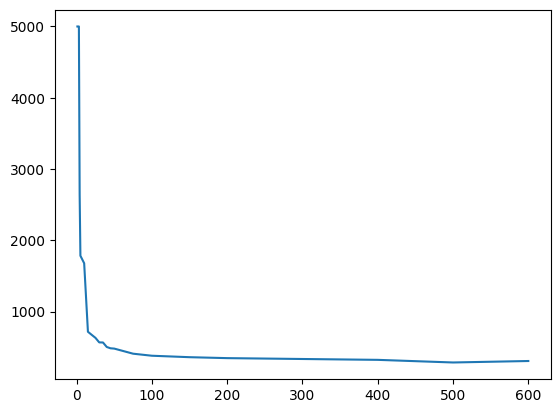

In [4]:
# plotting part a convergence results

experiments = [1, 2, 3, 4, 5,10,15,20,25,30,35,40,45,50,75,100,150,200,300,400,500,600]
experiment_result_avgs = [0 for _ in range(len(experiments))]

for i in range(len(all_results[0])):
    temp = [0 for _ in range(5)]
    for j in range(5):
        current = all_results[j][i]
        if current != -1:
            temp[j] = current
        else:
            # if nonconvergent just make equal to max gens
            # should mention this next to graph in report
            temp[j] = 5000
    experiment_result_avgs[i] = sum(temp) / len(temp)
    
print(experiment_result_avgs)

plt.plot(experiments, experiment_result_avgs)


In [23]:
# running experiment again using a way smaller number of evaluations and instead takign the fitnesses rather than the time to convergence
all_results = []
experiment_pop_sizes = [1, 2, 3, 4, 5,10,15,20,25,30,35,40,45,50,75,100,150,200,300,400,500,600,700,800,900,1000]

for _ in range(5):
    # TODO: make problem harder dims++, so that PSO has a harder time converging
    results = run_fitness_experiment(dims=5, no_of_evals=501, pop_sizes=experiment_pop_sizes)
    all_results.append(list(results.values()))
    
# Fitness in this context is the result of the Rastrigin function (not normalised to [0,1] range)
list(map(print, all_results))
print('\n')

avg_fit_results = [0 for _ in range(len(all_results[0]))]
for i in range(len(all_results[0])):
    temp = []
    for j in range(5):
        temp.append(all_results[j][i])
    avg_fit_results[i] = sum(temp) / 5
    
print(avg_fit_results)

{1: 75.2188678770016, 2: 7.439347615638866, 3: 16.029778689656204, 4: 0.11116597579031406, 5: 11.90513706498902, 10: 2.4963195344717235, 15: 7.08576840034285, 20: 2.988219888456001, 25: 0.007471678152654704, 30: 8.19582517195272e-05, 35: 1.0963773817707079e-06, 40: 1.9899442511209173, 45: 0.9949606271263747, 50: 0.0019398834799204678, 75: 0.0011654128912397255, 100: 0.9949838661382415, 150: 5.683668291567301e-08, 200: 3.1568490044264763e-09, 300: 4.068120063038805e-08, 400: 6.722871148667764e-09, 500: 8.892442338037654e-11, 600: 4.141043064009864e-11, 700: 1.9391421801628894e-10, 800: 3.126388037344441e-13, 900: 1.0099213909597893e-08, 1000: 3.623767952376511e-13}
{1: 20.52330696929379, 2: 16.168058549229897, 3: 16.190192048300688, 4: 6.795976675889435, 5: 7.337130646652447, 10: 3.1901346142982163, 15: 1.0025783843659895, 20: 0.9949630835063559, 25: 0.9961316557769493, 30: 1.9951517300873718, 35: 0.9954096660881788, 40: 0.00428950400331729, 45: 0.994968593287318, 50: 0.0248641862466740

<Axes: >

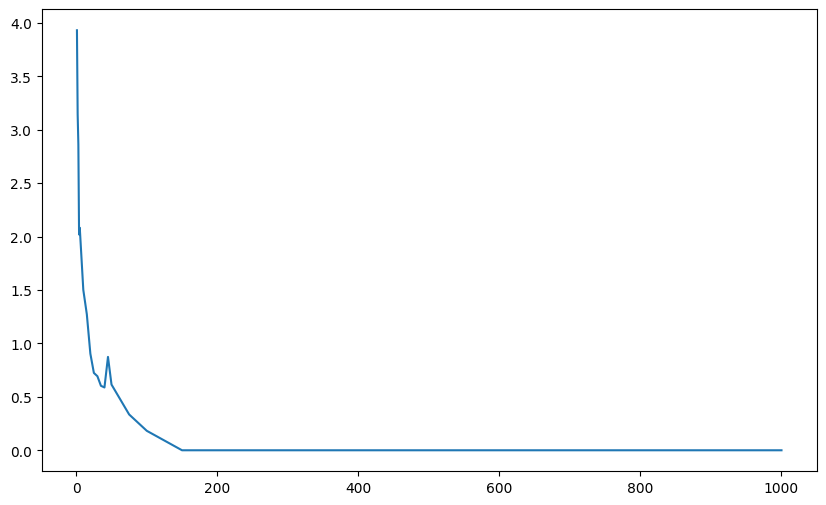

In [24]:
# plotting part a fitness results
# using natural log scale
plt.figure(figsize=(10,6))
sns.lineplot(x=experiment_pop_sizes, y=list(map(lambda x: math.log(1+x), avg_fit_results)))


In [25]:
# want to plot the results so fitness for higher populations is clearer,
# to do this I should remove the small populations...

In [26]:
# part b

all_conv_results = []
for i in range(2, 11):
    print("dims =", i)
    all_conv_results.append(run_convergence_experiment(dims=i, pop_sizes=[1, 2, 3, 4, 5,10,15,20,25,30,35,40,45,50,75,100,150,200,300,400,500]))
    print('\n')

dims = 2
{1: -1, 2: -1, 3: -1, 4: 602, 5: -1, 10: 395, 15: 349, 20: 279, 25: 328, 30: 388, 35: 332, 40: 299, 45: 255, 50: 307, 75: 240, 100: 219, 150: 199, 200: 212, 300: 203, 400: 144, 500: 204}


dims = 3
{1: -1, 2: -1, 3: -1, 4: 555, 5: 1441, 10: 743, 15: 630, 20: 771, 25: 559, 30: 552, 35: 566, 40: 570, 45: 458, 50: 461, 75: 396, 100: 401, 150: 402, 200: 393, 300: 379, 400: 330, 500: 304}


dims = 4
{1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 10: 1539, 15: 810, 20: 1184, 25: 988, 30: 905, 35: 784, 40: 586, 45: 877, 50: 756, 75: 666, 100: 667, 150: 632, 200: 547, 300: 515, 400: 531, 500: 445}


dims = 5
{1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 10: 2215, 15: 1243, 20: 1558, 25: -1, 30: 1418, 35: 1119, 40: 972, 45: 925, 50: 918, 75: 1320, 100: 781, 150: 720, 200: 794, 300: 628, 400: 784, 500: 616}


dims = 6
{1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 10: -1, 15: 2034, 20: -1, 25: -1, 30: -1, 35: 1668, 40: -1, 45: 1715, 50: 1570, 75: 1088, 100: 1401, 150: 918, 200: 893, 300: 1200, 400: 873, 500: 764}


di

In [6]:

# 2: {1: -1, 2: -1, 3: -1, 4: 602, 5: -1, 10: 395, 15: 349, 20: 279, 25: 328, 30: 388, 35: 332, 40: 299, 45: 255, 50: 307, 75: 240, 100: 219, 150: 199, 200: 212, 300: 203, 400: 144, 500: 204}
# 3: {1: -1, 2: -1, 3: -1, 4: 555, 5: 1441, 10: 743, 15: 630, 20: 771, 25: 559, 30: 552, 35: 566, 40: 570, 45: 458, 50: 461, 75: 396, 100: 401, 150: 402, 200: 393, 300: 379, 400: 330, 500: 304}
# 4: {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 10: 1539, 15: 810, 20: 1184, 25: 988, 30: 905, 35: 784, 40: 586, 45: 877, 50: 756, 75: 666, 100: 667, 150: 632, 200: 547, 300: 515, 400: 531, 500: 445}
# 5: {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 10: 2215, 15: 1243, 20: 1558, 25: -1, 30: 1418, 35: 1119, 40: 972, 45: 925, 50: 918, 75: 1320, 100: 781, 150: 720, 200: 794, 300: 628, 400: 784, 500: 616}
# 6: {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 10: -1, 15: 2034, 20: -1, 25: -1, 30: -1, 35: 1668, 40: -1, 45: 1715, 50: 1570, 75: 1088, 100: 1401, 150: 918, 200: 893, 300: 1200, 400: 873, 500: 764}
# 7: {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 10: -1, 15: -1, 20: -1, 25: -1, 30: 2490, 35: 2327, 40: 1886, 45: 2250, 50: -1, 75: -1, 100: 2087, 150: 1275, 200: 1570, 300: 1100, 400: 993, 500: 1061}
# 8: {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 10: -1, 15: -1, 20: -1, 25: -1, 30: -1, 35: -1, 40: -1, 45: -1, 50: -1, 75: 2288, 100: 1580, 150: 2037, 200: 1758, 300: 1436, 400: 1611, 500: 1418}
# 9: {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 10: -1, 15: -1, 20: -1, 25: -1, 30: -1, 35: -1, 40: -1, 45: -1, 50: -1, 75: -1, 100: -1, 150: -1, 200: 2481, 300: 1757, 400: 1816, 500: 1911}
# 10: {1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 10: -1, 15: -1, 20: -1, 25: -1, 30: -1, 35: -1, 40: -1, 45: -1, 50: -1, 75: -1, 100: -1, 150: -1, 200: -1, 300: -1, 400: -1, 500: 2252}



In [28]:
all_fir_results = []
for i in range(2, 11):
    print("dims =", i, "\n")
    all_fir_results.append(run_fitness_experiment(dims=i, no_of_evals=501, pop_sizes=[1, 2, 3, 4, 5,10,15,20,25,30,35,40,45,50,75,100,150,200,300,400,500]))

dims = 2 

{1: 14.476401605964586, 2: 1.9899183823075859, 3: 0.9949590570935314, 4: 0.24174832811938174, 5: 1.4162973727138706e-07, 10: 5.353939513952355e-12, 15: 0.0, 20: 0.0, 25: 0.0, 30: 0.0, 35: 0.0, 40: 0.0, 45: 0.0, 50: 0.0, 75: 0.0, 100: 0.0, 150: 0.0, 200: 0.0, 300: 0.0, 400: 0.0, 500: 0.0}
dims = 3 

{1: 54.8156792823944, 2: 1.0140221455978846, 3: 1.9899181879087138, 4: 0.0003231841474757857, 5: 0.9949591720491142, 10: 0.9949590570943769, 15: 1.3713474800169934e-12, 20: 9.485745522397337e-13, 25: 7.105427357601002e-15, 30: 1.8829382497642655e-13, 35: 2.1316282072803006e-14, 40: 1.7057288914656965e-10, 45: 0.0, 50: 7.105427357601002e-15, 75: 0.0, 100: 0.0, 150: 0.0, 200: 0.0, 300: 0.0, 400: 0.0, 500: 0.0}
dims = 4 

{1: 32.96897856022088, 2: 16.324635909861485, 3: 5.196939463854193, 4: 3.421837143035823, 5: 13.930040546528218, 10: 0.9991391313286684, 15: 0.023650773314820128, 20: 0.9949590570990239, 25: 8.469443741887517e-07, 30: 1.2104948154956219e-09, 35: 0.9949590583309629, 

In [ ]:
#2 {1: 14.476401605964586, 2: 1.9899183823075859, 3: 0.9949590570935314, 4: 0.24174832811938174, 5: 1.4162973727138706e-07, 10: 5.353939513952355e-12, 15: 0.0, 20: 0.0, 25: 0.0, 30: 0.0, 35: 0.0, 40: 0.0, 45: 0.0, 50: 0.0, 75: 0.0, 100: 0.0, 150: 0.0, 200: 0.0, 300: 0.0, 400: 0.0, 500: 0.0}
#3 {1: 54.8156792823944, 2: 1.0140221455978846, 3: 1.9899181879087138, 4: 0.0003231841474757857, 5: 0.9949591720491142, 10: 0.9949590570943769, 15: 1.3713474800169934e-12, 20: 9.485745522397337e-13, 25: 7.105427357601002e-15, 30: 1.8829382497642655e-13, 35: 2.1316282072803006e-14, 40: 1.7057288914656965e-10, 45: 0.0, 50: 7.105427357601002e-15, 75: 0.0, 100: 0.0, 150: 0.0, 200: 0.0, 300: 0.0, 400: 0.0, 500: 0.0}
#4 {1: 32.96897856022088, 2: 16.324635909861485, 3: 5.196939463854193, 4: 3.421837143035823, 5: 13.930040546528218, 10: 0.9991391313286684, 15: 0.023650773314820128, 20: 0.9949590570990239, 25: 8.469443741887517e-07, 30: 1.2104948154956219e-09, 35: 0.9949590583309629, 40: 3.6839855965808965e-07, 45: 6.245670647331281e-12, 50: 1.7404149495803267e-05, 75: 1.5483294646401191e-09, 100: 2.5011104298755527e-12, 150: 8.714096111361869e-10, 200: 0.0, 300: 0.0, 400: 0.0, 500: 0.0}
#5 {1: 75.19275128758497, 2: 40.30982396287412, 3: 7.430941073851656, 4: 9.414305640346825, 5: 1.8777304572268392, 10: 4.664463961340999, 15: 1.911027320361498, 20: 1.0439397145851217, 25: 0.994959121068355, 30: 0.1557520471675744, 35: 0.9974652231027861, 40: 0.0018081381057015733, 45: 1.1105071619715972, 50: 9.638376781140323e-06, 75: 2.6765295451980364e-05, 100: 5.9763686778069314e-05, 150: 1.904789215245728e-07, 200: 9.215675333962281e-09, 300: 0.011727332553029157, 400: 4.438049927557586e-11, 500: 2.1186018273056106e-08}
#6 {1: 44.387101398060935, 2: 20.73276076023859, 3: 11.197054217768205, 4: 19.045694524732177, 5: 12.351232034338402, 10: 12.80682438558432, 15: 2.1757347031771843, 20: 3.0484363946366955, 25: 0.012193652021686319, 30: 1.3028513387970975, 35: 0.9967847938844017, 40: 3.0553330775044003, 45: 2.99177706346876, 50: 2.0608848246891753, 75: 0.9954356495494849, 100: 1.7573957613625097, 150: 0.995030947548841, 200: 0.9975548528942682, 300: 1.8858079897654534e-07, 400: 4.162008011121543e-06, 500: 4.746908643937786e-09}
#7 {1: 70.73542269382783, 2: 59.24491238989211, 3: 15.349101842809283, 4: 11.086819694736143, 5: 39.43365741522459, 10: 4.8070266722452, 15: 11.534125343966345, 20: 12.085069221126695, 25: 7.08277212214594, 30: 4.907491034459554, 35: 3.0120182523587715, 40: 4.032127152779623, 45: 0.0170589113020867, 50: 4.139126984120978, 75: 4.373261235276587, 100: 4.147915492633501, 150: 2.006802106946594, 200: 1.045511190530874, 300: 1.0490330763665838, 400: 1.9910323884876107, 500: 3.95320991231074e-06}
#8 {1: 135.24266794390107, 2: 102.4247522701175, 3: 48.33800238629111, 4: 34.74024270323564, 5: 25.75519058086587, 10: 11.713775768847484, 15: 24.27087362216838, 20: 4.1655336094642905, 25: 3.7286952789857963, 30: 13.287861180429388, 35: 8.277289790023374, 40: 6.056863053184614, 45: 4.6532813691754455, 50: 3.3887304921069585, 75: 16.715512835273337, 100: 6.793367480100869, 150: 4.088494295036256, 200: 2.4696398722415154, 300: 1.9974028822049803, 400: 1.2406982203000894, 500: 3.0804076847399102}
#9 {1: 76.34322917489467, 2: 64.1114192980621, 3: 97.37677812511481, 4: 42.8039099795207, 5: 109.97127375859122, 10: 28.482413856820536, 15: 42.27269308732477, 20: 45.85264255637393, 25: 16.06908297755467, 30: 21.98820226440094, 35: 5.632669967794925, 40: 12.156696900360757, 45: 6.018797734936555, 50: 11.066560558608131, 75: 15.23576410550217, 100: 1.2177742142594354, 150: 6.118862434109289, 200: 3.378749505498945, 300: 2.3391217776251523, 400: 3.1146722825868807, 500: 1.490435489296928}
#10 {1: 143.5544792752387, 2: 146.45414903591063, 3: 110.26572677413765, 4: 51.61498668852282, 5: 55.99990252035628, 10: 64.94513887031741, 15: 34.66962622136829, 20: 31.11265628968509, 25: 29.05388351591222, 30: 56.79169303206784, 35: 24.89828950568821, 40: 21.6503543860983, 45: 10.12959348465698, 50: 26.55489114127947, 75: 20.504661201097235, 100: 13.275545333273769, 150: 7.874722511068981, 200: 9.594395356989864, 300: 8.503046393765032, 400: 1.1337206073429655, 500: 7.9304863037521045}

